<a href="https://colab.research.google.com/github/mounikagarikipati/US-stock-prediction/blob/main/US_stock_price_prediction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [1]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import warnings

from sklearn.metrics import *

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



import plotly.io as pio
import cufflinks as cf
import plotly.express as px
from sklearn.model_selection import GridSearchCV

pd.options.display.max_columns=None
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.plotting.backend = 'plotly'

pio.templates.default = "plotly"
cf.go_offline()

warnings.filterwarnings('ignore')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


# Load data

In [2]:
tickers = [
'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JNJ', 'XOM', 'V', 'WMT', 'NVDA', 'PG',
'LLY', 'CVX', 'MA', 'HD', 'PFE', 'ABBV', 'MRK', 'KO', 'PEP', 'AVGO', 'ORCL',
'TMO', 'AZN', 'CSCO', 'DHR', 'MCD', 'ABT', 'TMUS', 'ACN', 'NEE', 'VZ', 'TTE',
'LIN', 'DIS', 'PM', 'BMY', 'CMCSA', 'SCHW', 'UPS', 'TXN', 'RTX', 'COP'
]

In [3]:
from google.colab import files

uploaded = files.upload()

Saving AAPL_fundamentals_train.csv to AAPL_fundamentals_train.csv
Saving ABBV_fundamentals_train.csv to ABBV_fundamentals_train.csv
Saving ABT_fundamentals_train.csv to ABT_fundamentals_train.csv
Saving ACN_fundamentals_train.csv to ACN_fundamentals_train.csv
Saving AMZN_fundamentals_train.csv to AMZN_fundamentals_train.csv
Saving AVGO_fundamentals_train.csv to AVGO_fundamentals_train.csv
Saving AZN_fundamentals_train.csv to AZN_fundamentals_train.csv
Saving BMY_fundamentals_train.csv to BMY_fundamentals_train.csv
Saving CMCSA_fundamentals_train.csv to CMCSA_fundamentals_train.csv
Saving COP_fundamentals_train.csv to COP_fundamentals_train.csv
Saving CSCO_fundamentals_train.csv to CSCO_fundamentals_train.csv
Saving CVX_fundamentals_train.csv to CVX_fundamentals_train.csv
Saving DHR_fundamentals_train.csv to DHR_fundamentals_train.csv
Saving DIS_fundamentals_train.csv to DIS_fundamentals_train.csv
Saving GOOGL_fundamentals_train.csv to GOOGL_fundamentals_train.csv
Saving HD_fundamentals

In [5]:
dfs = []

# Read data for each company and append to the list
for ticker in tickers:
    file_path = f"{ticker}_fundamentals_train.csv"
    #file_path = os.path.join('E:/Data/train/Fundamentals/', f"{ticker}_fundamentals_train.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        dfs.append(df)
    else:
        print(f"Data file not found for {ticker}.")

# Combine all dataframes into a single dataframe
df = pd.concat(dfs, ignore_index=True)

In [6]:
df.shape

(111802, 33)

In [7]:
df.head()

,Date,close,volume,ttm_net_eps,pe_ratio,ttm_sales_per_share,book_value_per_share,ttm_fcf_per_share,current_assets,current_ratio,current_assets___inventory,quick_ratio,total_liabilities,debt_to_equity_ratio,return_on_equity,return_on_assets,tangible_equity,return_on_tangible_equity,current_liabilities,shareholder's_equity,ttm_net_income,cash_on_hand,total_share_holder_equity,revenue,gross_profit,operating_income,ebitda,net_income,eps_earnings_per_share_diluted,ps_ratio,pb_ratio,pfcf_ratio,total_assets
0,2009-03-31,3.200,570080000.000,0.254,19.776,1.480,0.970,0.601,33.850,2.460,33.540,2.440,18.930,0.780,30.049,17.333,30.774,30.597,13.750,24.310,7.437,24503.361,24058.626,11804.590,4728.644,3431.932,3593.407,2457.580,0.104,3.494,4.517,12.662,50.609
1,2009-04-01,3.309,589372000.000,0.254,19.776,1.480,0.970,0.601,33.850,2.460,33.540,2.440,18.930,0.780,30.049,17.333,30.774,30.597,13.750,24.310,7.437,24503.361,24058.626,11804.590,4728.644,3431.932,3593.407,2457.580,0.104,3.494,4.517,12.662,50.609
2,2009-04-02,3.431,812366800.000,0.254,19.776,1.480,0.970,0.601,33.850,2.460,33.540,2.440,18.930,0.780,30.049,17.333,30.774,30.597,13.750,24.310,7.437,24503.361,24058.626,11804.590,4728.644,3431.932,3593.407,2457.580,0.104,3.494,4.517,12.662,50.609
3,2009-04-03,3.531,636241200.000,0.254,19.776,1.480,0.970,0.601,33.850,2.460,33.540,2.440,18.930,0.780,30.049,17.333,30.774,30.597,13.750,24.310,7.437,24503.361,24058.626,11804.590,4728.644,3431.932,3593.407,2457.580,0.104,3.494,4.517,12.662,50.609
4,2009-04-06,3.606,658064400.000,0.254,19.776,1.480,0.970,0.601,33.850,2.460,33.540,2.440,18.930,0.780,30.049,17.333,30.774,30.597,13.750,24.310,7.437,24503.361,24058.626,11804.590,4728.644,3431.932,3593.407,2457.580,0.104,3.494,4.517,12.662,50.609


# Data Preprocessing

<h3 style="color: blue;">handling missing values</h3>

In [8]:
#checking for missing values
df.isna().sum().to_frame().sort_values(by=0, ascending=False).sum()

0    0
dtype: int64

<h3 style="color: blue;">handling duplicates</h3>

In [9]:
#checking for duplicates
df.duplicated().any()

False

<h3 style="color: blue;">handle outliers</h3>

In [10]:
# Function to count outliers using IQR method
def count_outliers(df):
    outliers = 0
    for column in df:
        if df[column].dtype != 'object':
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers += df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
    return outliers

# Count outliers in the dataframe 'df'
num_outliers = count_outliers(df)

# Print the number of outliers
print(f"Number of outliers in the dataframe: {num_outliers}")


Number of outliers in the dataframe: 272324


In [11]:
# # Function to handle outliers using the median replacement method
# def handle_outliers(dfnout):
#     for column in dfnout:
#         if dfnout[column].dtype != 'object':
#             Q1 = dfnout[column].quantile(0.25)
#             Q3 = dfnout[column].quantile(0.75)
#             IQR = Q3 - Q1
#             lower_bound = Q1 - 1.5 * IQR
#             upper_bound = Q3 + 1.5 * IQR
#             dfnout[column] = dfnout[column].apply(lambda x: dfnout[column].median() if x < lower_bound or x > upper_bound else x)
#     return dfnout
# # Handle outliers in the dataframe 'df' using median replacement
# dfnout = handle_outliers(df)


<h3 style="color: blue;">Data encoding</h3>

In [12]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns excluding 'Date'
for column in df.columns:
    if df[column].dtype == 'object' and column != 'Date':
        df[column] = label_encoder.fit_transform(df[column])

# Display the encoded dataframe
df.head()


,Date,close,volume,ttm_net_eps,pe_ratio,ttm_sales_per_share,book_value_per_share,ttm_fcf_per_share,current_assets,current_ratio,current_assets___inventory,quick_ratio,total_liabilities,debt_to_equity_ratio,return_on_equity,return_on_assets,tangible_equity,return_on_tangible_equity,current_liabilities,shareholder's_equity,ttm_net_income,cash_on_hand,total_share_holder_equity,revenue,gross_profit,operating_income,ebitda,net_income,eps_earnings_per_share_diluted,ps_ratio,pb_ratio,pfcf_ratio,total_assets
0,2009-03-31,3.200,570080000.000,0.254,19.776,1.480,0.970,0.601,33.850,2.460,33.540,2.440,18.930,0.780,30.049,17.333,30.774,30.597,13.750,24.310,7.437,24503.361,24058.626,11804.590,4728.644,3431.932,3593.407,2457.580,0.104,3.494,4.517,12.662,50.609
1,2009-04-01,3.309,589372000.000,0.254,19.776,1.480,0.970,0.601,33.850,2.460,33.540,2.440,18.930,0.780,30.049,17.333,30.774,30.597,13.750,24.310,7.437,24503.361,24058.626,11804.590,4728.644,3431.932,3593.407,2457.580,0.104,3.494,4.517,12.662,50.609
2,2009-04-02,3.431,812366800.000,0.254,19.776,1.480,0.970,0.601,33.850,2.460,33.540,2.440,18.930,0.780,30.049,17.333,30.774,30.597,13.750,24.310,7.437,24503.361,24058.626,11804.590,4728.644,3431.932,3593.407,2457.580,0.104,3.494,4.517,12.662,50.609
3,2009-04-03,3.531,636241200.000,0.254,19.776,1.480,0.970,0.601,33.850,2.460,33.540,2.440,18.930,0.780,30.049,17.333,30.774,30.597,13.750,24.310,7.437,24503.361,24058.626,11804.590,4728.644,3431.932,3593.407,2457.580,0.104,3.494,4.517,12.662,50.609
4,2009-04-06,3.606,658064400.000,0.254,19.776,1.480,0.970,0.601,33.850,2.460,33.540,2.440,18.930,0.780,30.049,17.333,30.774,30.597,13.750,24.310,7.437,24503.361,24058.626,11804.590,4728.644,3431.932,3593.407,2457.580,0.104,3.494,4.517,12.662,50.609


# Exploratory Data Analysis (EDA)

<h3 style="color: blue;">statistical summariess</h3>

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
close,111802.000,52.801,40.298,1.927,25.258,41.969,68.211,305.122
volume,111802.000,21448972.137,59081987.394,162400.000,3843300.000,7330400.000,16489100.000,1133344800.000
ttm_net_eps,111802.000,3.171,2.352,-5.690,1.440,2.750,4.520,15.180
pe_ratio,111802.000,22.248,111.890,-1548.000,11.574,15.674,22.776,1620.000
ttm_sales_per_share,111802.000,30.229,30.857,-5.580,9.150,19.620,40.890,180.250
book_value_per_share,111802.000,17.039,16.352,-11.420,6.900,11.500,22.940,104.300
ttm_fcf_per_share,111802.000,3.147,2.652,-6.600,1.450,2.940,4.650,22.840
current_assets,111802.000,29.611,28.468,0.560,10.610,18.430,41.690,238.520
current_ratio,111802.000,1.786,1.265,0.270,1.060,1.400,2.000,11.910
current_assets___inventory,111802.000,22.754,27.452,0.000,4.680,13.630,30.030,187.990


<h3 style="color: blue;">Correlation</h3>

In [14]:
numeric_attributes = df.iloc[:, :10]

# Compute the correlation matrix
correlation_matrix = numeric_attributes.corr()
correlation_matrix

,close,volume,ttm_net_eps,pe_ratio,ttm_sales_per_share,book_value_per_share,ttm_fcf_per_share,current_assets,current_ratio
close,1.000,-0.214,0.572,0.020,0.317,0.358,0.540,-0.114,-0.109
volume,-0.214,1.000,-0.220,0.019,-0.188,-0.185,-0.167,0.192,0.112
ttm_net_eps,0.572,-0.220,1.000,-0.068,0.594,0.469,0.506,0.001,-0.198
pe_ratio,0.020,0.019,-0.068,1.000,-0.038,-0.037,-0.021,-0.007,0.001
ttm_sales_per_share,0.317,-0.188,0.594,-0.038,1.000,0.543,0.323,0.136,-0.307
book_value_per_share,0.358,-0.185,0.469,-0.037,0.543,1.000,0.211,0.081,-0.159
ttm_fcf_per_share,0.540,-0.167,0.506,-0.021,0.323,0.211,1.000,-0.043,-0.082
current_assets,-0.114,0.192,0.001,-0.007,0.136,0.081,-0.043,1.000,0.111
current_ratio,-0.109,0.112,-0.198,0.001,-0.307,-0.159,-0.082,0.111,1.000


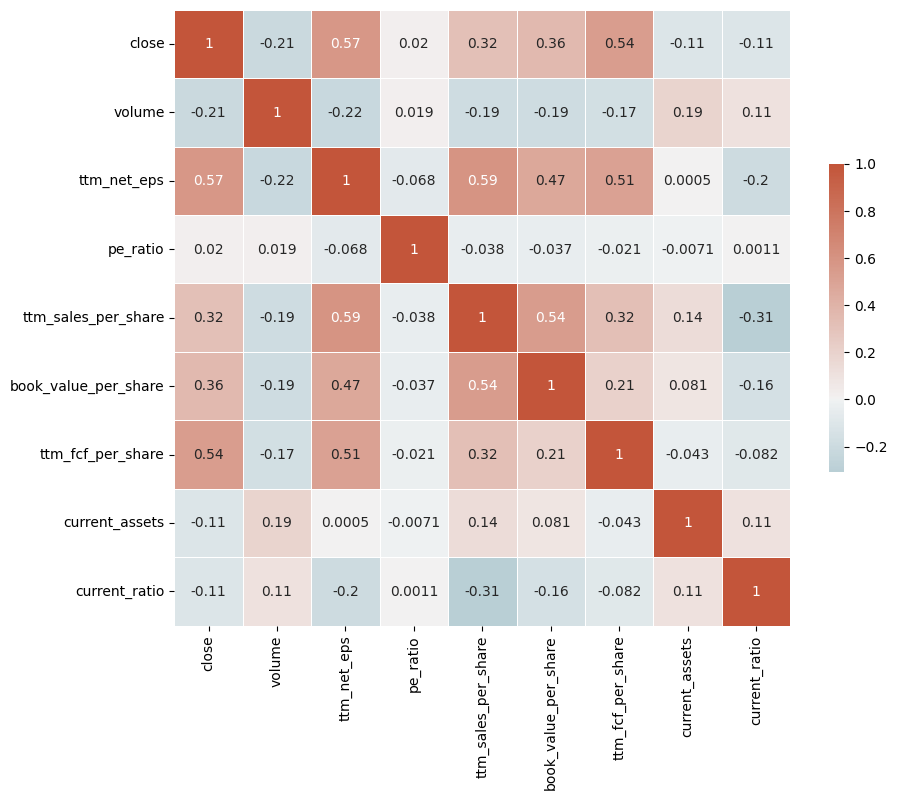

In [15]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show the plot
plt.show()

<h3 style="color: blue;">distribution plots</h3>

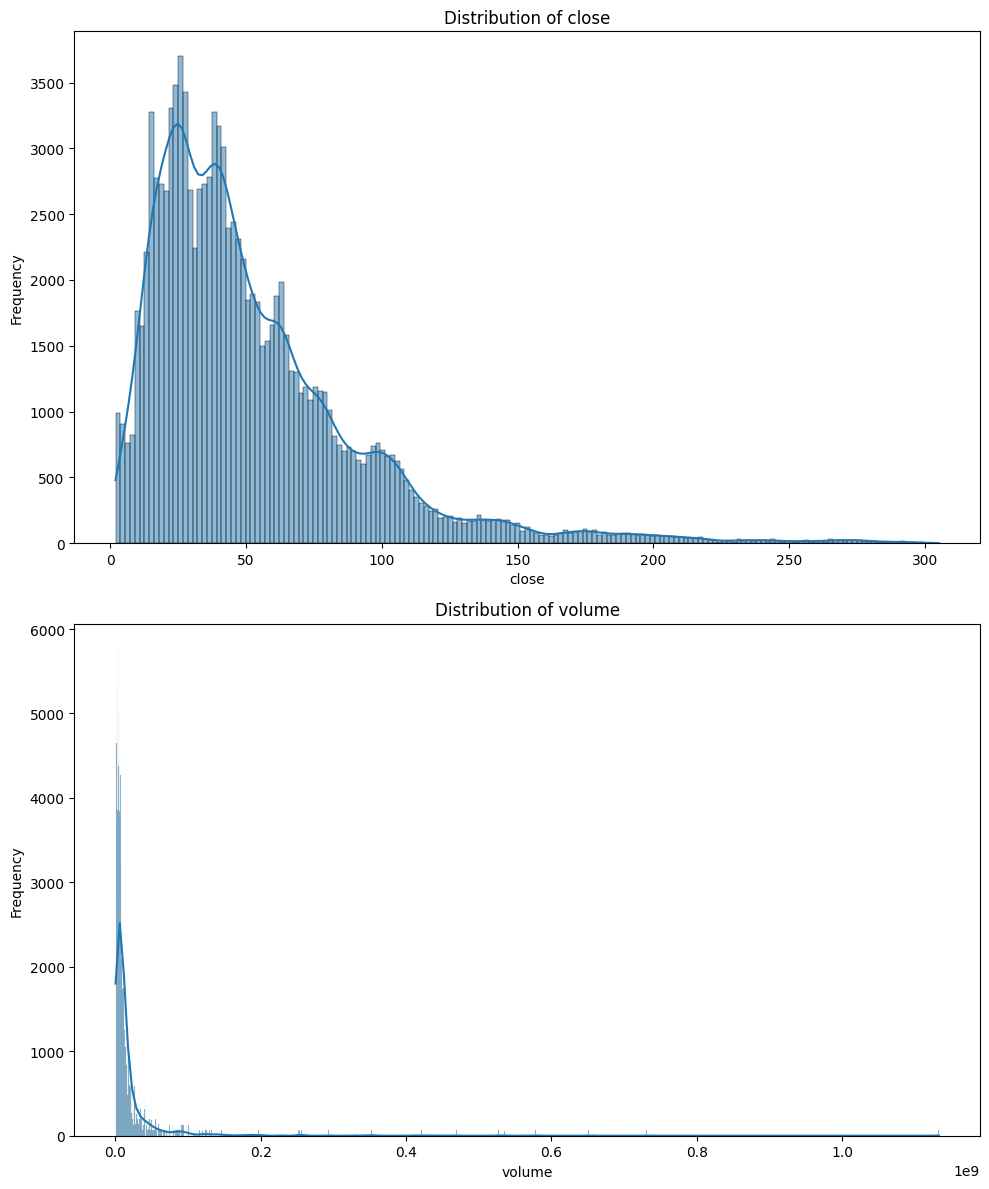

In [16]:
# Select the volume and close attributes
stock_attributes = df[['close', 'volume']]

# Set up the figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plot the distribution of each attribute
for i, column in enumerate(stock_attributes.columns):
    sns.histplot(stock_attributes[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}', fontsize=12)
    axes[i].set_xlabel(column, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()


<h3 style="color: blue;">time series trends</h3>

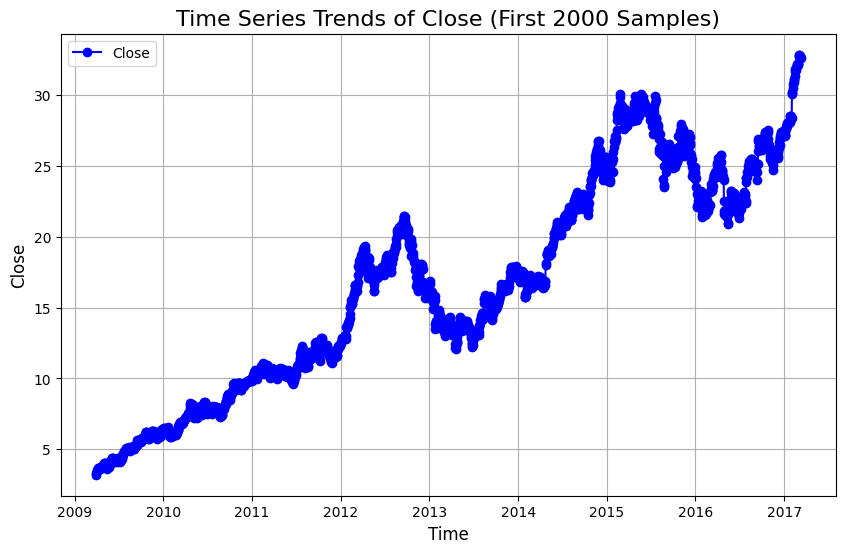

In [17]:
# Convert the 'Date' column to datetime for time-based plotting
df['Date'] = pd.to_datetime(df['Date'])

# Select the first 2000 samples
df_first_2000 = df.head(2000)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the time series trend of 'Close' using 'Date' as the x-axis
ax.plot(df_first_2000['Date'], df_first_2000['close'], marker='o', linestyle='-', color='b', label='Close')

# Set the title and labels
ax.set_title('Time Series Trends of Close (First 2000 Samples)', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Close', fontsize=12)

# Show grid and legend
ax.grid(True)
ax.legend()

# Show the plot
plt.show()


# Feature Selection

In [18]:
# Separate features and target excluding 'Date'
X = df.drop(['close', 'Date'], axis=1)
y = df[['close']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the RFE object and specify the model to be used
estimator = LinearRegression()
selector = RFE(estimator, step=1)

# Fit the RFE
selector = selector.fit(X_train, y_train)

# Determine the optimal number of features
optimal_num_features = selector.n_features_

# Retrieve the selected feature rankings
feature_rankings = selector.ranking_

# Determine the most relevant N features excluding 'Date'
selected_features = X.columns[selector.support_]

# Print the optimal number of features and the selected features
print(f"Optimal number of features: {optimal_num_features}")
print(f"Selected features: {selected_features}")


Optimal number of features: 15
Selected features: Index(['ttm_net_eps', 'book_value_per_share', 'ttm_fcf_per_share',
       'current_assets', 'current_ratio', 'current_assets___inventory',
       'quick_ratio', 'total_liabilities', 'debt_to_equity_ratio',
       'current_liabilities', 'ttm_net_income',
       'eps_earnings_per_share_diluted', 'ps_ratio', 'pb_ratio',
       'total_assets'],
      dtype='object')


# Baseline Model

In [19]:
#Baseline model
X = df[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 24.176362318231043


In [20]:

# Calculate R2 score
baseline_model_r2 = r2_score(y_test, y_pred)

# Convert R2 score to percentage
baseline_model_r2_percentage = baseline_model_r2 * 100

# Print the R2 score as a percentage
print(f"Accuracy of the linear regression model: {baseline_model_r2_percentage:.2f}%")


Accuracy of the linear regression model: 63.07%


# ARIMA Model

In [21]:
# Grid search for finding the best hyperparameters
warnings.filterwarnings("ignore")

best_rmse = float('inf')
best_order = None

for p, d, q in product(range(3), range(2), range(3)):
    try:
        model = ARIMA(y_train, order=(p, d, q))
        model_fit = model.fit()
        y_pred = model_fit.forecast(steps=len(y_test))

        rmse = mean_squared_error(y_test, y_pred, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_order = (p, d, q)

    except:
        continue

# Train the ARIMA model with the best parameters
model = ARIMA(y_train, order=best_order)
model_fit = model.fit()

# Make predictions
start_idx = len(y_train)
y_pred = model_fit.forecast(steps=len(y_test))

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R2 score
arima_r2 = r2_score(y_test, y_pred)

# Convert R2 score to percentage
arima_r2_percentage = arima_r2 * 100

# Print the R2 score as a percentage
print(f"Accuracy of the linear regression model: {arima_r2_percentage:.2f}%")



Root Mean Squared Error (RMSE): 39.78574317405985
Accuracy of the linear regression model: -0.01%


# LSTM Model

In [22]:
# Train LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=16, verbose=0)
lstm_predictions = lstm_model.predict(X_test_reshaped)
lstm_predictions = lstm_predictions.reshape(lstm_predictions.shape[0])

# Calculate LSTM RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
print(f"LSTM RMSE: {lstm_rmse}")




699/699 [==============================] - 2s 2ms/step
LSTM RMSE: 6.6381112787318814


In [23]:
# Calculate R2 score
lstm_r2 = r2_score(y_test, lstm_predictions)

# Convert R2 score to percentage
lstm_r2_percentage = lstm_r2 * 100

# Print the R2 score as a percentage
print(f"LSTM R2 Score: {lstm_r2_percentage:.2f}%")

LSTM R2 Score: 97.22%


# XGBoost model

In [24]:
# Train XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Calculate XGBoost RMSE
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))

# Print the RMSEs

print(f"XGBoost RMSE: {xgb_rmse}")

XGBoost RMSE: 2.6961416062215267


In [25]:
# Calculate R2 score
Xgb_r2 = r2_score(y_test, xgb_predictions)

# Convert R2 score to percentage
Xgb_r2_percentage = Xgb_r2 * 100

# Print the R2 score as a percentage
print(f"XGBOOST R2 Score: {Xgb_r2_percentage:.2f}%")

XGBOOST R2 Score: 99.54%


# Model Comparison

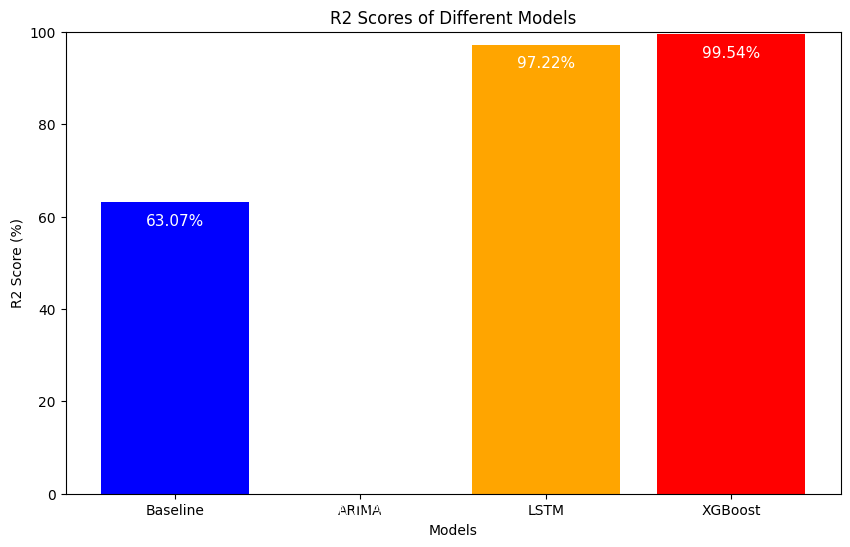

In [26]:
# R2 scores and model names
model_names = ['Baseline', 'ARIMA', 'LSTM', 'XGBoost']
r2_scores = [baseline_model_r2, arima_r2, lstm_r2, Xgb_r2]

# Convert R2 scores to percentages
r2_scores_percentage = [score * 100 for score in r2_scores]

# Plot the bar chart
plt.figure(figsize=(10,6))
bars = plt.bar(model_names, r2_scores_percentage, color=['blue', 'green', 'orange', 'red'])
plt.title('R2 Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('R2 Score (%)')
plt.ylim(0, 100)  # Set the y-axis limit to 100

# Adding values to the bars
for bar, r2_score in zip(bars, r2_scores_percentage):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f'{r2_score:.2f}%', ha='center', color='white', fontsize=11)

plt.show()


# Model Deployment

In [27]:
# Create an instance with arbitrary values
new_instance = pd.DataFrame([[1.5, 20.0, 2.0, 5000000, 1.2, 300000, 1.0, 1000000, 0.5,
                              200000, 1000000, 0.5, 1.2, 2.0, 1.5]],
                            columns=selected_features)

# Predict the close price for the new instance
predicted_close_price = xgb_model.predict(new_instance)

# Display the predicted close price
print("Predicted Close Price:")
print(predicted_close_price)


Predicted Close Price:
[32.15207]
